#### China Scrappage Program Notebook
Author: Aaron Yu  
Last Modified June 27, 2019

# Table of Contents
1. [Objective/Research Question](#Objective/Research-Question)
1. [Setup](#Setup)
    1. [Packages](#Packages)
    1. [Input Data](#Input-Data)

# Objective/Research Question
In recent years, China has worked to reduce air pollution from motor vehicles by progressively tightening its emissions standards for new vehicles. In lieu of a study conducted in 2011 by China's Ministry of Environmental Protection (MEP) which showed that despite the fact that what are known as yellow-label vehicles, vehicles with yellow environmental labels to their windshields, only account for 16% of China's fleet, they account for 87% of the Particulate Matter (PM) emmited from all vehicles nationwide, China has also implemented an ambitious large-scale vehicle scrappage program to accelerate the retirement of older vehicles. We are refining our emission inventory model inputs for China to more accurately reflect the emissions and fleet impacts of China's scrappage program. In this workbook, we estimate the shape of the survival curves that best represent actual historical vehicle retirement patterns in China over the past decade. We estimate specific survival curves by vehicle type and vehicle emission standard.

# Setup
To find incomplete tasks, search for [todo].  
Read in new sales data without rounding error

## Packages


In [1]:
# Load standard packages
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.widgets import Slider, Button, RadioButtons

# Load custom packages
'''
from common.common import *
from common import emissions_calc
'''

# Settings
pd.options.mode.chained_assignment = None

## Input Data
We are using three sets of data to estimate our survival curves for each vehicle type and emmission standard in China. The first data set is a breakdown of China's fleet in 2016 by vehicle type, size, fuel and emission standard. The second data set is a table of new vehicle sales by vehicle type and years, from 1985-2017. The third dataset is an implementation timeline for China's new vehicle standards, from China 0 (Uncontrolled) to China 6.

Chinva Vehicle Stock in 2016, sorted by vehicle type and standard

In [2]:
targetStock = pd.read_excel("inputs/China-stock-by-vehicle-and-standard-2016.xls")
keep = ['Vehicle','Fuel', 'China 0', 'China 1', 'China 2', 'China 3', 'China 4', 'China 5']
targetStock = targetStock.loc[:,keep]
targetStock = pd.melt(targetStock, id_vars = ['Vehicle','Fuel'], var_name = 'Standard', value_name = 'Stock')
targetStock = targetStock.groupby(by = ['Vehicle', 'Standard','Fuel'])['Stock'].sum().reset_index()
targetStock.head()

,Vehicle,Standard,Fuel,Stock
0,Bus,China 0,diesel,5222.333333
1,Bus,China 0,gasoline,48494.500000
2,Bus,China 0,others,53.666667
3,Bus,China 1,diesel,17996.333333
4,Bus,China 1,gasoline,39225.166667


Sales data from 1985 to 2017

In [3]:
salesData = pd.read_excel("inputs/China-new-vehicle-sales.xlsx",skiprows=1)
#Sales Data is measured in units of 1000s
salesData['NewSales'] = salesData['NewSales']*1000 #Converts sales data from thousands to units
# This analysis focuses on Diesel and Gasoline vehicles
salesData = salesData.loc[salesData.Fuel.isin(['Diesel', 'Gasoline'])]
#TODO: Use dictionary and create a new variable to convert Vehicle type to VehCat in NewStd Timeline
vtypeTovcat = {"Bus":"HDV","HDT":"HDV","LCV":"LDV","PC":"LDV","MDT":"HDV", "MC":"MC"}
salesData['VehCat'] = salesData['Vehicle']
salesData['VehCat'].replace(vtypeTovcat,inplace=True)
salesData.head()

,Vehicle,Fuel,Year,NewSales,VehCat
0,Bus,Diesel,1985,2618.515640,HDV
1,Bus,Diesel,1986,20063.988973,HDV
2,Bus,Diesel,1987,29194.133420,HDV
3,Bus,Diesel,1988,24613.156271,HDV
4,Bus,Diesel,1989,41558.347660,HDV


Let's look at China's in-use fleet in 2016 by vehicle type and emission standard. Let's start with HDT.  

In [4]:
hdtData = targetStock.loc[targetStock["Vehicle"] == "HDT"]
hdtData.reset_index(inplace=True,drop=True)
hdtData

#Graphic
#hdtData = hdtData.set_index('Standard')["Stock"].to_dict()
#labels = hdtData.keys()
#sizes = hdtData.values()
#plt.close()
#plt.pie(sizes, labels = labels,autopct='%1.1f%%', shadow=True,pctdistance=1.2,labeldistance=1.35)
#plt.axis('equal')
#plt.show()

,Vehicle,Standard,Fuel,Stock
0,HDT,China 0,diesel,8.993333e+02
1,HDT,China 0,gasoline,1.505000e+02
2,HDT,China 1,diesel,4.364567e+04
3,HDT,China 1,gasoline,2.741667e+02
4,HDT,China 2,diesel,2.417500e+05
5,HDT,China 2,gasoline,8.777333e+03
6,HDT,China 3,diesel,3.225518e+06
7,HDT,China 3,gasoline,4.829500e+03
8,HDT,China 4,diesel,2.099366e+06
9,HDT,China 4,gasoline,5.705000e+02


Let's look at China's new vehicle sales over time by vehicle type. We'll start with buses as an example.

In [5]:
busSalesData = salesData.loc[salesData["Vehicle"]=="Bus"]
busSalesData.reset_index(inplace=True,drop=True)
busSalesData.head()

#Graphic
#busSalesData= busSalesData.set_index('Year')["NewSales"].to_dict()
#plt.close()
#plt.plot(busSalesData.keys(),busSalesData.values())
#plt.xlabel("Year")
#plt.ylabel("Sales")
#plt.title("Diesel Bus Sales in China from 1985-2017")
#plt.show()


,Vehicle,Fuel,Year,NewSales,VehCat
0,Bus,Diesel,1985,2618.515640,HDV
1,Bus,Diesel,1986,20063.988973,HDV
2,Bus,Diesel,1987,29194.133420,HDV
3,Bus,Diesel,1988,24613.156271,HDV
4,Bus,Diesel,1989,41558.347660,HDV


# Timeline of Emission Standards
In this section we are reading in data regarding when various emission standards where implemented (China 0-5). This data will later be melted with the sales data to make it easier to check survival curve accuracy.

In [6]:
standardsData = pd.read_excel("inputs/Model-inputs-global-2019.xlsx",sheet_name="NewStd",usecols="A:F")
standardsData = standardsData.loc[(standardsData.ISO=='CHN') & (standardsData.Scenario=='Baseline')]
standardsData.rename(columns={"MY":"Year"},inplace=True)
standardsData.head()


,ISO,Fuel,VehCat,Year,NewVehCtrl,Scenario
208,CHN,Diesel,HDV,1970,China 0,Baseline
209,CHN,Diesel,HDV,2001,China 1,Baseline
210,CHN,Diesel,HDV,2004,China 2,Baseline
211,CHN,Diesel,HDV,2008,China 3,Baseline
212,CHN,Diesel,HDV,2013,China 4,Baseline


# Calculations
In this section we are created a table of melted data using salesData and standardsData in order to attach the corresponding standard for each set of vehicles sold in a given year.

In [7]:
mergedSalesData = pd.merge(salesData, standardsData, how="left", on=["VehCat","Fuel", "Year"])
mergedSalesData.sort_index(inplace=True)
#todo Group by vehicle type and fuel type and use transform to ensure ffill doesn't spill into next group
mergedSalesData["ISO"].fillna("CHN",inplace=True)
groupvars = ['Vehicle', 'Fuel']
mergedSalesData["Scenario"].fillna("Baseline",inplace=True)
mergedSalesData["NewVehCtrl"] = mergedSalesData.groupby(groupvars)["NewVehCtrl"].transform(lambda x: x.fillna(method="ffill"))
mergedSalesData["NewVehCtrl"].fillna("China 0",inplace=True)
mergedSalesData

,Vehicle,Fuel,Year,NewSales,VehCat,ISO,NewVehCtrl,Scenario
0,Bus,Diesel,1985,2.618516e+03,HDV,CHN,China 0,Baseline
1,Bus,Diesel,1986,2.006399e+04,HDV,CHN,China 0,Baseline
2,Bus,Diesel,1987,2.919413e+04,HDV,CHN,China 0,Baseline
3,Bus,Diesel,1988,2.461316e+04,HDV,CHN,China 0,Baseline
4,Bus,Diesel,1989,4.155835e+04,HDV,CHN,China 0,Baseline
5,Bus,Diesel,1990,3.987047e+04,HDV,CHN,China 0,Baseline
6,Bus,Diesel,1991,4.885140e+04,HDV,CHN,China 0,Baseline
7,Bus,Diesel,1992,8.485064e+04,HDV,CHN,China 0,Baseline
8,Bus,Diesel,1993,6.439338e+04,HDV,CHN,China 0,Baseline
9,Bus,Diesel,1994,5.326021e+04,HDV,CHN,China 0,Baseline


# Survival Curve
We define survival curves using the following functional form:  
$$SR_{i,m} = exp(-(\frac{t}{T_{i,m}})^{k_{i,m}})$$  
This essentially tells us what percent of vehicles should be surviving at a given based on two variables, $T_m$ and $K_m$.

In [8]:
def survcurve(t, Tm = 15.505, Km = 4):
    
    '''Generate a point on a survival curve.
    
    Parameters
    ----------
    t : int (required)
        vehicle age in years.
    Tm : int (optional)
        approximation of the average vehicle retirement age
    Km : int (optional)
        characteristic parameter that defines the steepness of the curve
        
    Returns
    _______
    float : percent of vehicles surviving at age t
    '''
    return round(np.exp(-(t/Tm)**Km),4)

# China 4 Gasoline Passenger Cars

## Extracting the Corresponding Data
In this section we write a function called extractData that extracts data fron the mergedSalesData table given a vehicle type, fuel type, and standard.



In [9]:
def extractData(vehicle, standard,fuel):
    data = mergedSalesData.loc[mergedSalesData["Vehicle"]==vehicle]
    data = data.loc[data["NewVehCtrl"] == standard]
    data = data.loc[data["Fuel"]==fuel]
    return data

## Calibrating Survival Curve
In this section we are calibrating our survival curve to test its accuracy for China 4 Gasoline Passenger Cars. Since our targetStock data ends in 2016, the age of the vehicle will be determined by $2016 - $its sales year.

In [10]:
#generic survival curve, 
def survcurve(t, Tm = 5.10, Km = 26.40):
    t = 2016-t
    '''Generate a point on a survival curve.
    
    Parameters
    ----------
    t : int (required)
        vehicle age in years.
    Tm : int (optional)
        approximation of the average vehicle retirement age
    Km : int (optional)
        characteristic parameter that defines the steepness of the curve
        
    Returns
    _______
    float : percent of vehicles surviving at age t
    '''
    return round(np.exp(-(t/Tm)**Km),4)

## Extracting China 4 Gasoline PC Data
In this section we just use our extractData function to extract the correct data from mergedSalesData

In [11]:
salesDataSurvivalCurve = extractData("PC","China 4", "Gasoline")
salesDataSurvivalCurve.head()

,Vehicle,Fuel,Year,NewSales,VehCat,ISO,NewVehCtrl,Scenario
349,PC,Gasoline,2011,1.130850e+07,LDV,CHN,China 4,Baseline
350,PC,Gasoline,2012,1.534217e+07,LDV,CHN,China 4,Baseline
351,PC,Gasoline,2013,1.776536e+07,LDV,CHN,China 4,Baseline
352,PC,Gasoline,2014,1.980440e+07,LDV,CHN,China 4,Baseline
353,PC,Gasoline,2015,2.101180e+07,LDV,CHN,China 4,Baseline


## Applying the Survival Curve
In this section we apply the survival curve to our salesDataSurvivalCurve data by attaching a column called Age that gives the vehicle age and Percent Survivng that contains the percent of vehicles that should be survivng in a given year based on its age. Finally we create a column called Surviving Vehicles, which is the number of cars surviving for a given year, calculated from Percent Surviving x NewSales.

In [12]:
salesDataSurvivalCurve["Age"] = salesDataSurvivalCurve["Year"].apply(lambda x: 2016-x)
salesDataSurvivalCurve["Percent Surviving"] = salesDataSurvivalCurve["Year"].apply(survcurve)
salesDataSurvivalCurve["Surviving Vehicles"] = salesDataSurvivalCurve.apply(lambda x: x[3]*x[9],axis=1)
salesDataSurvivalCurve.reset_index(inplace=True,drop =True)
salesDataSurvivalCurve.head()

,Vehicle,Fuel,Year,NewSales,VehCat,ISO,NewVehCtrl,Scenario,Age,Percent Surviving,Surviving Vehicles
0,PC,Gasoline,2011,1.130850e+07,LDV,CHN,China 4,Baseline,5,0.5527,6.250209e+06
1,PC,Gasoline,2012,1.534217e+07,LDV,CHN,China 4,Baseline,4,0.9984,1.531762e+07
2,PC,Gasoline,2013,1.776536e+07,LDV,CHN,China 4,Baseline,3,1.0000,1.776536e+07
3,PC,Gasoline,2014,1.980440e+07,LDV,CHN,China 4,Baseline,2,1.0000,1.980440e+07
4,PC,Gasoline,2015,2.101180e+07,LDV,CHN,China 4,Baseline,1,1.0000,2.101180e+07


## Data Comparison
In this section we do a quick comparison from the targetStock to the salesDataSurvivalCurve. We get the total surviving cars by summing up the SurvivingVehicles column in salesDataSurvivalCurve. We can also easily extract the needed data from targetStock

In [24]:
targetStockData = targetStock.loc[(targetStock["Vehicle"] == "PC") &(targetStock["Standard"] == "China 4") &(targetStock["Fuel"]=="gasoline")]["Stock"]
print(targetStockData)
survivalStock = salesDataSurvivalCurve["Surviving Vehicles"].sum()
print(survivalStock)

67    84590575.75
Name: Stock, dtype: float64
104155960.0940498


# Miscellaneous
This section just contains code for an interactive survival curve graph that may be implemented at a later time,.

<IPython.core.display.Javascript object>


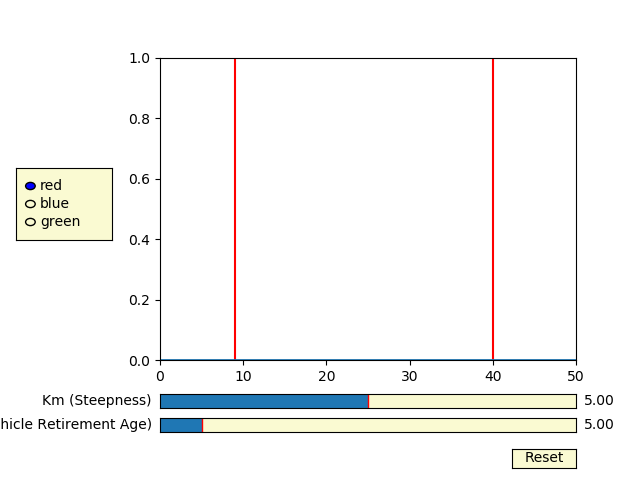

In [13]:
#apply survival curve to sales data
plt.close()
#Returns percentage accuracy
def checkAccuracy(vehicle,standard,fuel,tm,km):
    TotalVehicles = 0
    data = extractData(vehicle,standard,fuel)
    for index, row in data.iterrows():
        year = int(row['Year'])
        sales = int(row['NewSales'])
        TotalVehicles += survcurve((2016-year),tm,km)*sales
    print("Estimate:" + str(TotalVehicles))
    actual = targetStock.loc[targetStock['vehicle']==vehicle]
    actual = actual.loc[actual["Standard"] == standard]
    actual = actual.loc[actual["fuel"] == fuel.lower()]
    actual = int(actual["Stock"])
    print("Actual:" + str(actual))
                             


fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)
t = [i/20 for i in range(1000)]
s = [survcurve(i) for i in t]
plt.axvline(x=9,color='red')
plt.axvline(x=40,color='red')
l, = plt.plot(t, s, lw=2)
plt.axis([0, 50, 0, 1])

axcolor = 'lightgoldenrodyellow'
axTm = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axKm = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

Tm = Slider(axTm, 'Tm (Average Vehicle Retirement Age)', 0, 50, valinit=5, valstep=.1)
Km = Slider(axKm, 'Km (Steepness)', 0, 10, valinit=5, valstep = .1)


def update(val):
    global t
    Tmval = Tm.val
    Kmval = Km.val
    l.set_ydata([survcurve(i,Tmval,Kmval) for i in t])
    print(checkAccuracy("PC","China 0","Diesel",Tmval,Kmval))
    fig.canvas.draw_idle()

Tm.on_changed(update)
Km.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    Tm.reset()
    Km.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)

#Add scrappage value lines

plt.show()

In [14]:
#compare estimated stock with actual stock